# Denoising 1d signal

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
plt.rc("text", usetex=True)
plt.rc('font', family='serif', size=14)

In [2]:
def plot_compare(x_true, x_pred):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].plot(x_pred["x"], label="pred")
    axs[0].plot(x_true["x"], label="true")
    axs[0].legend()
    axs[0].set(xlabel=r"$t$", ylabel=r"$x(t)$")
    axs[1].plot(x_pred["x'"].ravel(), label="pred")
    axs[1].plot(x_true["x'"], label="true")
    axs[1].legend()
    axs[1].set(xlabel=r"$t$", ylabel=r"$x'(t)$")
    fig.tight_layout()
    
def plot_data(x, y):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(x, label=r"$x(t)$")
    ax.plot(y, ".", label=r"$y(t)$")
    ax.legend()
    ax.set(xlabel=r"$t$")

In [3]:
from tramp.priors import GaussBernouilliPrior, GaussianPrior
from tramp.channels import GaussianChannel, GradientChannel
from tramp.variables import SISOVariable as V, SILeafVariable as O, MILeafVariable, SIMOVariable
from tramp.experiments import TeacherStudentScenario

## Sparse gradient denoising

We use sparsity of $\nabla x$ as prior information.

In [4]:
def get_sparse_grad_student(size, grad_rho, noise_var):
    x_shape = (size,)
    grad_shape = (1,) + x_shape
    student = (
        GaussianPrior(size=x_shape) @
        SIMOVariable(id="x", n_next=2) @ (
            GaussianChannel(var=noise_var) @ O("y") 
            + (
                GradientChannel(shape=x_shape) +
                GaussBernouilliPrior(size=grad_shape, rho=grad_rho)
            ) @ MILeafVariable(id="x'", n_prev=2)
        )
    ).to_model()
    return student

In [5]:
class SparseGradTeacher():
    def __init__(self, size, grad_rho, noise_var):
        self.prior_grad = GaussBernouilliPrior(size=size, rho=grad_rho)
        self.channel = GaussianChannel(var=noise_var)
    def sample(self, seed=None):
        if seed:
            np.random.seed(seed)
        x_prime = self.prior_grad.sample()
        x = x_prime.cumsum()
        x = x - x.mean()
        y = self.channel.sample(x)
        return {"x":x, "x'":x_prime, "y":y}

In [6]:
teacher = SparseGradTeacher(size=100, grad_rho=0.04, noise_var=0.01)
student = get_sparse_grad_student(size=100, grad_rho=0.04, noise_var=0.01)
scenario = TeacherStudentScenario(teacher, student, x_ids=["x", "x'"])

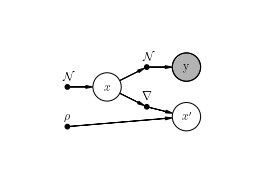

In [7]:
scenario.setup(seed=1)
scenario.student.plot()

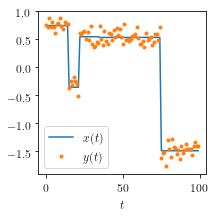

In [8]:
plot_data(scenario.x_true["x"], scenario.observations["y"])

In [9]:
from tramp.algos import EarlyStoppingEP
_ = scenario.run_ep(max_iter=200, damping=0.1, callback=EarlyStoppingEP(tol=1e-2))

INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=0,b=0)
INFO:tramp.algos.message_passing:f_1->x damping=0.1
INFO:tramp.algos.message_passing:f_2->x' damping=0.1
INFO:tramp.algos.message_passing:f_0->x' damping=0.1
INFO:tramp.algos.message_passing:x<-f_2 damping=0.1
INFO:tramp.algos.message_passing:x<-f_3 damping=0.1
INFO:tramp.algos.callbacks:early stopping all tolerances (on r) are below tol=1.00e-02
INFO:tramp.algos.message_passing:terminated after n_iter=12 iterations


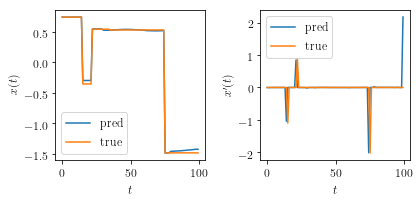

In [10]:
plot_compare(scenario.x_true, scenario.x_pred)

## L2 gradient denoising

We use as variance of $\nabla x$ as prior information. Note that we are only using a L2 penalty (gaussian prior) on the gradient. A much better prior would use the fact that $x(t)$ is smooth, for instance using L2 penalty (gaussian prior) on higher derivatives of $x$.

In [11]:
def get_L2_grad_student(size, prior_var, grad_var, noise_var):
    x_shape = (size,)
    grad_shape = (1,) + x_shape
    student = (
        GaussianPrior(size=x_shape, var=prior_var) @
        SIMOVariable(id="x", n_next=2) @ (
            GaussianChannel(var=noise_var) @ O("y") 
            + (
                GradientChannel(shape=x_shape) +
                GaussianPrior(size=grad_shape, var=grad_var)
            ) @ MILeafVariable(id="x'", n_prev=2)
        )
    ).to_model()
    return student

In [12]:
class SmoothGradTeacher():
    def __init__(self, size, noise_var):
        self.t = np.linspace(-2*np.pi,2*np.pi, size, endpoint=False)
        self.channel = GaussianChannel(var=noise_var)
    def sample(self, seed=None, verbose=False):
        if seed:
            np.random.seed(seed)
        x_prime = np.cos(self.t)
        x = x_prime.cumsum()
        y = self.channel.sample(x)
        if verbose:
            print(f"SmoothGradTeacher: var(x') = {x_prime.var(): .3f} var(x)={x.var(): .3f}")
        return {"x":x, "x'":x_prime, "y":y}

In [13]:
s= SmoothGradTeacher(size=100, noise_var=1).sample(verbose=True)

SmoothGradTeacher: var(x') =  0.500 var(x)= 31.705


In [14]:
teacher = SmoothGradTeacher(size=100, noise_var=1)
student = get_L2_grad_student(size=100, prior_var=30, grad_var=0.5, noise_var=1)
scenario = TeacherStudentScenario(teacher, student, x_ids=["x", "x'"])

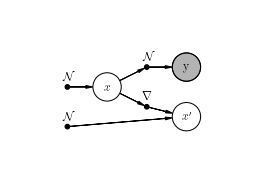

In [15]:
scenario.setup(seed=1)
scenario.student.plot()

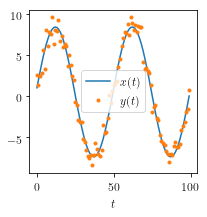

In [16]:
plot_data(scenario.x_true["x"], scenario.observations["y"])

In [17]:
_ = scenario.run_ep(max_iter=200, damping=0, callback=EarlyStoppingEP(tol=1e-2))

INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=0,b=0)
INFO:tramp.algos.message_passing:no damping
INFO:tramp.algos.callbacks:early stopping all tolerances (on r) are below tol=1.00e-02
INFO:tramp.algos.message_passing:terminated after n_iter=3 iterations


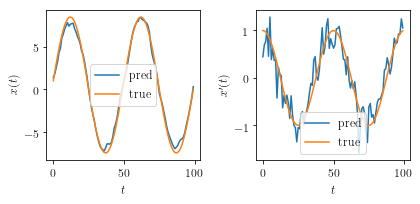

In [18]:
plot_compare(scenario.x_true, scenario.x_pred)